<a href="https://colab.research.google.com/github/Sat-A/s5-jax/blob/main/s5-AR-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S5-Tokenised

The goal of this exercise is to adapt an annotated implementation of S5 https://github.com/JPGoodale/annotated-s5 that was made for classification tasks to regression tasks.

# Runtime Setup
Ensure runtime is set to GPU to ensure gpu parallelisation speedup

In [1]:
# %%
!pip --quiet install dm-haiku hippox yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 14.3 MB/s eta 0:00:00


In [2]:
# %%
# Core JAX, Haiku, and Optax
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from functools import partial
from typing import NamedTuple, Optional, Tuple, MutableMapping, Any

# Data loading and plotting
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Imports from your original notebook
import torch
from hippox.main import Hippo
from tqdm import tqdm
import dataclasses

First we'll define some helper functions for discretization and timescale initialization as the SSM equation is naturally continuous and must be made discrete to be unrolled as a linear recurrence like standard RNNs.

In [3]:
# Here we are just using the zero order hold method for its sheer simplicity, with A, B and delta_t denoting the
# state matrix, input matrix and change in timescale respectively.

def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity)) * B
    return _A, _B

# This is a function used to initialize the trainable timescale parameter.
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(shape, dtype):
        uniform = hk.initializers.RandomUniform()
        return uniform(shape, dtype)*(jnp.log(dt_max) - jnp.log(dt_min)) + jnp.log(dt_min)
    return init

# Taken directly from https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/recurrent.py
def add_batch(nest, batch_size: Optional[int]):
    broadcast = lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape)
    return jax.tree_util.tree_map(broadcast, nest)

The linear SSM equation is as follows:
$$ x_0(t) = Ax(t) + Bu(t) $$
$$ y(t) = Cx(t) + Du(t) $$

 We will now implement it as a recurrent Haiku module:

In [4]:
class LinearSSM(hk.RNNCore):
    def __init__(self, state_size: int, name: Optional[str] = None):
        super(LinearSSM, self).__init__(name=name)
        # We won't get into the basis measure families here, just note that they are basically just the
        # type of orthogonal polynomial we initialize with, the scaled Legendre measure (LegS) introduced
        # in the original HiPPO paper is pretty much the standard initialization and is what is used in the
        # main experiments in the S5 paper. I will also note that the Hippo class uses the diagonal representation
        # of the state matrix by default, as this has become the standard in neural SSMs since shown to be
        # equally effective as the diagonal plus low rank representation in https://arxiv.org/abs/2203.14343
        # and then formalized in https://arxiv.org/abs/2206.11893.

        _hippo = Hippo(state_size=state_size, basis_measure='legs')
        # Must be called for parameters to be initialized
        _hippo()

        # We register the real and imaginary components of the state matrix A as separate parameters because
        # they will have separate gradients in training, they will be conjoined back together and then discretized
        # but this will simply be backpropagated through as a transformation of the lambda real and imaginary
        # parameters (lambda is just what we call the diagonalized state matrix).

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            shape=[state_size,],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            shape=[state_size,],
            init=_hippo.lambda_initializer('imaginary')
        )
        self._A = self._lambda_real + 1j * self._lambda_imag

       # For now, these initializations of the input and output matrices B and C match the S4D
        # parameterization for demonstration purposes, we will implement the S5 versions later.

        self._B = hk.get_parameter(
            'B',
            shape=[state_size,],
            init=_hippo.b_initializer()
        )
        self._C = hk.get_parameter(
            'C',
            shape=[state_size, 2],
            init=hk.initializers.RandomNormal(stddev=0.5**0.5)
        )
        self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        # This feed-through matrix basically acts as a residual connection.
        self._D = hk.get_parameter(
            'D',
            [1,],
            init=jnp.ones,
        )

        self._delta_t = hk.get_parameter(
            'delta_t',
            shape=[1,],
            init=log_step_initializer()
        )
        timescale = jnp.exp(self._delta_t)

        self._state_matrix, self._input_matrix = discretize(self._A, self._B, timescale)

    def __call__(self, inputs, prev_state):
        u = inputs[:, jnp.newaxis]
        new_state = self._state_matrix @ prev_state + self._input_matrix @ u
        y_s = self._output_matrix @ new_state
        out = y_s.reshape(-1).real + self._D * u
        return out, new_state

    def initial_state(self, batch_size: Optional[int] = None):
        state = jnp.zeros([self._state_size])
        if batch_size is not None:
            state = add_batch(state, batch_size)
        return state

You may notice that this looks an awful lot like a vanilla RNN cell, just with our special parameterization and without any activations, hence being a linear recurrence. I have initialized it as an instance of Haiku's RNN.Core abstract base class so that it can be unrolled using either the hk.dynamic_unroll or hk.static_unroll functions like any other recurrent module, however, if you are familiar with any of the S4 models you may be noticing that there's something crucial missing here: the convolutional representation. One of the key contributions of the S4 paper was its demonstration that the SSM ODE can be represented as either a linear recurrence, as above, for efficient inference, or as a global convolution for much faster training. That paper and the following papers then go on to present various kernels for efficiently computing this convolution with Fast Fourier Transforms, highly improving the computational efficiency of the model. Then why have we omitted them? Because the S5 architecture which we are about to explore simplifies all this by providing a purely recurrent representation in both training and inference, it does this by using a parallel recurrence that actually looks alot like a convolution itself! From the paper:

    "We use parallel scans to efficiently compute the states of a discretized linear SSM. Given a binary associative operator • (i.e. (a • b) • c = a • (b • c)) and a sequence of L elements [a1, a2, ..., aL], the scan operation (sometimes referred to as all-prefix-sum) returns the sequence [a1, (a1 • a2), ..., (a1 • a2 • ... • aL)]."

Let's see what this looks like in code, taken straight from the original author's implementation:

In [5]:
@jax.vmap
def binary_operator(q_i, q_j):
    A_i, b_i = q_i
    A_j, b_j = q_j
    return A_j * A_i, A_j * b_i + b_j

def parallel_scan(A, B, C, inputs):
    A_elements = A * jnp.ones((inputs.shape[0], A.shape[0]))
    Bu_elements = jax.vmap(lambda u: B @ u)(inputs)
    # Jax's built-in associative scan really comes in handy here as it executes a similar scan
    # operation as used in a normal recurrent unroll but is specifically tailored to fit an associative
    # operation like the one described in the paper.
    _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))
    return jax.vmap(lambda x: (C @ x).real)(xs)

It's that simple! In the original S4 we would have had to apply an independent singe-input, single-output (SISO) SSM for each feature of the input sequence such as in this excerpt from Sasha Rush's Flax implementation:



```python
def cloneLayer(layer):
    return flax.linen.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)
```



Whereas in the S5 we process the entire sequence in one multi-input, multi-output (MIMO) layer.

Let's now rewrite our Module as a full S5 layer using this new method, we will be adding a few extra conditional arguments as well as changing some parameterization to match the original paper, but we'll walk through the reason for all these changes below.

In [6]:
# First we add a new helper function for the timescale initialization, this one just takes the previous
# log_step_initializer and stores a bunch of them in an array since our model is now multi-in, multi-out.

def init_log_steps(shape, dtype):
    H = shape[0]
    log_steps = []
    for i in range(H):
        log_step = log_step_initializer()(shape=(1,), dtype=dtype)
        log_steps.append(log_step)

    return jnp.array(log_steps)

In [7]:
# We will also rewrite our discretization for the MIMO context
def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity))[..., None] * B
    return _A, _B

In [8]:
class S5(hk.Module):
    def __init__(self,
                 state_size: int,

                 # Now that we're MIMO we'll need to know the number of input features, commonly
                 # referred to as the dimension of the model.
                 d_model: int,

                 # We must also now specify the number of blocks that we will split our matrices
                 # into due to the MIMO context.
                 n_blocks: int,

                 # Short for conjugate symmetry, because our state matrix is complex we can half
                 # the size of it since complex numbers are a real and imaginary number joined together,
                 # this is not new to the S5, we just didn't mention it above.
                 conj_sym: bool = True,

                 # Another standard SSM argument that we omitted above for simplicity's sake,
                 # this forces the real part of the state matrix to be negative for better
                 # stability, especially in autoregressive tasks.
                 clip_eigns: bool = False,

                 # Like most RNNs, the S5 can be run in both directions if need be.
                 bidirectional: bool = False,

                 # Rescales delta_t for varying input resolutions, such as different audio
                 # sampling rates.
                 step_rescale: float = 1.0,
                 name: Optional[str] = None
    ):
        super(S5, self).__init__(name=name)
        self.conj_sym = conj_sym
        self.bidirectional = bidirectional

        # Note that the Hippo class takes conj_sym as an argument and will automatically half
        # the state size provided in its initialization, which is why we need to provide a local
        # state size that matches this for the shape argument in hk.get_parameter().

        if conj_sym:
            _state_size = state_size // 2
        else:
            _state_size = state_size

        # With block_diagonal set as True and the number of blocks provided, our Hippo class
        # will automatically handle this change of structure.

        _hippo = Hippo(
            state_size=state_size,
            basis_measure='legs',
            conj_sym=conj_sym,
            block_diagonal=True,
            n_blocks=n_blocks,
        )
        _hippo()

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            [_state_size],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            [_state_size],
            init=_hippo.lambda_initializer('imaginary')
        )
        if clip_eigns:
            self._lambda = jnp.clip(self._lambda_real, None, -1e-4) + 1j * self._lambda_imag
        else:
            self._A = self._lambda_real + 1j * self._lambda_imag

        # If you recall, I mentioned above that we are automatically using a diagonalized version of
        # the HiPPO state matrix rather than the pure one, due to it being very hard to efficiently
        # compute. I will now go into a little more detail on how this diagonal representation is
        # derived, as it is important for how we initialize the input and output matrices. The diagonal
        # decomposition of our state matrix is based on equivalence relation on the SSM parameters:
        # (A, B, C) ∼ (V−1AV ,V−1B, CV) with V being the eigenvector of our original A matrix and V-1
        # being the inverse eigenvector. The Hippo class has already performed the decomposition of A
        # into (V-1AV) automatically, but we have not yet performed the decomposition of B and C, we will
        # use the eigenvector_transform class method for that below, but first we must initialize B and C
        # as normal distributions, lecun normal and truncated normal respectively. I will note that there
        # are a few other options provided for C in the original repository but, to keep it simple, we will
        # just use one here.

        b_init = hk.initializers.VarianceScaling()
        b_shape = [state_size, d_model]
        b_init = b_init(b_shape, dtype=jnp.complex64)
        self._B = hk.get_parameter(
            'B',
            [_state_size, d_model, 2],
            init=_hippo.eigenvector_transform(b_init,  concatenate=True),
        )
        B = self._B[..., 0] + 1j * self._B[..., 1]

        c_init = hk.initializers.TruncatedNormal()
        c_shape = [d_model, state_size, 2]
        c_init = c_init(c_shape, dtype=jnp.complex64)
        self._C = hk.get_parameter(
            'C',
            [d_model, _state_size, 2],
            init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
        )
        # We need two output heads if bidirectional is True.
        if bidirectional:
            self._C2 = hk.get_parameter(
                'C2',
                [d_model, _state_size, 2],
                init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
            )
            C1 = self._C[..., 0] + 1j * self._C[..., 1]
            C2 = self._C2[..., 0] + 1j * self._C2[..., 1]
            self._output_matrix = jnp.concatenate((C1, C2), axis=-1)
        else:
            self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        self._D = hk.get_parameter(
            'D',
            [d_model,],
            init=hk.initializers.RandomNormal(stddev=1.0)
        )

        self._delta_t = hk.get_parameter(
            'delta_T',
            [_state_size, 1],
            init=init_log_steps
        )
        timescale = step_rescale * jnp.exp(self._delta_t[:, 0])

        # We could also use the bilinear discretization method, but we'll just stick to zoh for now.
        self._state_matrix, self._input_matrix = discretize(self._A, B, timescale)


    def __call__(self, inputs):
        # Note that this is the exact same function as presented above just with alternate procedures
        # depending on the bidirectional and conjugate symmetry arguments

        A_elements = self._state_matrix * jnp.ones((inputs.shape[0], self._state_matrix.shape[0]))
        Bu_elements = jax.vmap(lambda u: self._input_matrix @ u)(inputs)

        _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))

        if self.bidirectional:
            _, xs2 = jax.lax.associative_scan(binary_operator,
                                          (A_elements, Bu_elements),
                                          reverse=True)
            xs = jnp.concatenate((xs, xs2), axis=-1)

        if self.conj_sym:
            ys = jax.vmap(lambda x: 2*(self._output_matrix @ x).real)(xs)
        else:
            ys = jax.vmap(lambda x: (self._output_matrix @ x).real)(xs)

        Du = jax.vmap(lambda u: self._D * u)(inputs)

        return ys + Du

There we have it, a complete S5 layer! Now let's form a block around it using a structure very similar to a transformer block with a Gated Linear Unit (GLU).

In [9]:
import dataclasses

@dataclasses.dataclass
class S5Block(hk.Module):
    ssm: S5
    d_model: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Block, self).__post_init__()
        # We could use either layer norm or batch norm.
        self._norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
        self._linear = hk.Linear(self.d_model)

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self._norm(x)

        x = self.ssm(x)
        # There are a couple of other GLU patterns we could use here, but once again I have chosen
        # one semi-arbitrarily to avoid cluttering our module with if statements.
        x1 = hk.dropout(hk.next_rng_key(), self.dropout_rate, jax.nn.gelu(x))
        x = x * jax.nn.sigmoid(self._linear(x1))
        x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        x = skip + x
        if not self.prenorm:
            x = self._norm(x)

        return x

Now let's make a stack of these blocks:

In [10]:
@dataclasses.dataclass
class S5Stack(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Stack, self).__post_init__(name=self.name)
        self._encoder = hk.Linear(self.d_model)
        self._layers = [
            S5Block(
                ssm=self.ssm,
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                istraining=self.istraining,
                prenorm=self.prenorm,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        x = self._encoder(x)
        for layer in self._layers:
            x = layer(x)
        return x

# Implementing Tokenised prediction in S5

In [11]:
# %%
# --- S5 Model Hyperparameters ---
STATE_SIZE: int = 256
D_MODEL: int = 128
N_LAYERS: int = 6
N_BLOCKS: int = 4
DROPOUT_RATE: float = 0.1

# --- Task & Training Hyperparameters ---
VOCAB_SIZE: int = 1024       # Number of "log-return bins"
BATCH_SIZE: int = 64
EPOCHS: int = 30
LEARNING_RATE: float = 1e-3
SEED = 0

# ⭐️ NEW: Sequence Lengths for Seq2Seq
PROMPT_LEN: int = 256        # "Encoder" input length (history)
FORECAST_HORIZON: int = 50   # "Decoder" output length (future)
SEQ_LEN: int = PROMPT_LEN + FORECAST_HORIZON # Total sequence length for training

# --- Set random seeds ---
torch.random.manual_seed(SEED)
key = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(key)

In [12]:
# %%
class StockPriceTokeniser:
    """
    ⭐️ UPDATED: A quantisation tokeniser for LOG-RETURNS.
    Converts continuous log-returns into discrete integer tokens.
    """
    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.bins = None
        self.min_return = -0.1
        self.max_return = 0.1

    def fit(self, log_returns: jnp.ndarray):
        """Fits the tokeniser to the log-return data."""
        # Use quantiles for a more robust binning vs. simple min/max
        # This prevents outliers from dominating the range.
        self.min_return = jnp.quantile(log_returns, 0.01)
        self.max_return = jnp.quantile(log_returns, 0.99)
        # Create vocab_size-1 thresholds for binning
        self.bins = jnp.linspace(self.min_return, self.max_return, self.vocab_size - 1)
        print(f"[*] Tokeniser fitted: min_return={self.min_return:.4f}, max_return={self.max_return:.4f}")

    def encode(self, log_returns: jnp.ndarray) -> jnp.ndarray:
        """Converts a sequence of log-returns into token IDs."""
        if self.bins is None:
            raise ValueError("Tokeniser must be fitted before encoding.")
        # jnp.digitize bins values. Values < min go to bin 0, > max go to bin vocab_size-1
        token_ids = jnp.digitize(log_returns, self.bins)
        return token_ids.astype(jnp.int32)

    def decode_tokens_to_returns(self, token_ids: jnp.ndarray) -> jnp.ndarray:
        """Converts token IDs back into approximate log-return values (bin centres)."""
        if self.bins is None:
            raise ValueError("Tokeniser must be fitted before decoding.")

        # Create bin centres
        bin_edges = jnp.concatenate([
            jnp.array([self.min_return]),
            self.bins,
            jnp.array([self.max_return])
        ])
        bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        # Map tokens to bin centres
        log_returns = bin_centres[token_ids]
        return log_returns

    def decode(self, token_ids: jnp.ndarray, start_price: float) -> jnp.ndarray:
        """
        ⭐️ NEW: Decodes tokens back into a price sequence.
        Needs a starting price to reconstruct the prices from log-returns.
        """
        log_returns = self.decode_tokens_to_returns(token_ids)

        # Cumulatively sum log-returns and add to the log of the start price
        log_prices = jnp.log(start_price) + jnp.cumsum(log_returns)

        # Prepend the start price (converted to log) to the sequence
        full_log_prices = jnp.concatenate([jnp.array([jnp.log(start_price)]), log_prices])

        # Convert back to regular prices
        prices = jnp.exp(full_log_prices)

        # Return all prices *except* the start price
        return prices[1:]

In [13]:
# %%
@dataclasses.dataclass
class S5Forecaster(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    vocab_size: int
    dropout_rate: float
    prenorm: bool = True
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Forecaster, self).__post_init__(name=self.name)
        self._embedding = hk.Embed(
            vocab_size=self.vocab_size,
            embed_dim=self.d_model
        )
        self._s5_stack = S5Stack(
            ssm=self.ssm,
            d_model=self.d_model,
            n_layers=self.n_layers,
            dropout_rate=self.dropout_rate,
            istraining=self.istraining,
            prenorm=self.prenorm,
        )
        self._decoder = hk.Linear(self.vocab_size)

    def __call__(self, token_ids: jnp.ndarray) -> jnp.ndarray:
        x = self._embedding(token_ids)
        x = self._s5_stack(x)
        logits = self._decoder(x)
        return logits

In [14]:
# %%
# --- Training State and Optimizer ---
class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng_key: jnp.ndarray

_Metrics = MutableMapping[str, Any]

# --- Loss and Accuracy Functions ---
def loss_fn(
    params: hk.Params,
    rng_key: jnp.ndarray,
    model: hk.Transformed,
    inputs: jnp.ndarray, # Shape [Batch, SeqLen]
    targets: jnp.ndarray, # Shape [Batch, SeqLen]
    prompt_len: int      # ⭐️ NEW: Length of the prompt to mask
) -> jnp.ndarray:

    logits = model.apply(params, rng_key, inputs)

    # Calculate cross-entropy loss for all tokens
    loss_per_token = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits,
        labels=targets
    )

    # ⭐️ UPDATED: Only compute loss on the "forecast" part
    # We mask out the loss from the "prompt" tokens
    forecast_loss = loss_per_token[:, prompt_len:]

    return jnp.mean(forecast_loss)

def accuracy_fn(
    params: hk.Params,
    rng_key: jnp.ndarray,
    model: hk.Transformed,
    inputs: jnp.ndarray,
    targets: jnp.ndarray,
    prompt_len: int      # ⭐️ NEW: Length of the prompt to mask
) -> jnp.ndarray:

    logits = model.apply(params, rng_key, inputs)
    predictions = jnp.argmax(logits, axis=-1)

    # ⭐️ UPDATED: Only compute accuracy on the "forecast" part
    forecast_predictions = predictions[:, prompt_len:]
    forecast_targets = targets[:, prompt_len:]

    accuracy = jnp.mean(forecast_predictions == forecast_targets)
    return accuracy

# --- Update and Evaluate Functions ---
@partial(jax.jit, static_argnums=(2, 3)) # ⭐️ UPDATED: prompt_len is static
def update(
    state: TrainingState,
    batch: Tuple[jnp.ndarray, jnp.ndarray],
    model: hk.Transformed,
    prompt_len: int # ⭐️ NEW
) -> Tuple[TrainingState, _Metrics]:

    inputs, targets = batch
    rng_key, next_rng_key = jax.random.split(state.rng_key)

    # ⭐️ UPDATED: Pass prompt_len to loss_fn
    (loss, gradients) = jax.value_and_grad(loss_fn)(
        state.params,
        rng_key,
        model,
        inputs,
        targets,
        prompt_len
    )

    updates, new_opt_state = optim.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng_key=next_rng_key,
    )

    metrics = {'loss': loss}
    return new_state, metrics


@partial(jax.jit, static_argnums=(2, 3)) # ⭐️ UPDATED: prompt_len is static
def evaluate(
    state: TrainingState,
    batch: Tuple[jnp.ndarray, jnp.ndarray],
    model: hk.Transformed,
    prompt_len: int # ⭐️ NEW
) -> _Metrics:

    inputs, targets = batch

    # ⭐️ UPDATED: Pass prompt_len to loss/accuracy
    loss = loss_fn(state.params, state.rng_key, model, inputs, targets, prompt_len)
    accuracy = accuracy_fn(state.params, state.rng_key, model, inputs, targets, prompt_len)

    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

In [15]:
# %%
@partial(jax.jit, static_argnums=(0, 2))
def generate_forecast(
    model_init_fn,
    params: hk.Params,
    steps_to_forecast: int,
    prompt_tokens: jnp.ndarray, # Shape [PROMPT_LEN]
    rng_key: jnp.ndarray
):
    # This generation function works by "rolling" the input window.
    # It's an efficient way to do auto-regression for a model
    # that expects a fixed-length input.

    # Define the forward function for generation (istraining=False)
    @hk.transform
    def forward_generate(x) -> hk.transform:
        s5_ssm = S5(STATE_SIZE, D_MODEL, N_BLOCKS)
        neural_net = S5Forecaster(
            ssm=s5_ssm,
            d_model=D_MODEL,
            n_layers=N_LAYERS,
            vocab_size=VOCAB_SIZE,
            dropout_rate=0.0,
            istraining=False,
        )
        return neural_net(x) # Processes one sequence [SEQ_LEN]

    # The prompt_tokens must be the *full* length the model expects
    # We will pad it to SEQ_LEN and roll it.
    # ⭐️ Update: We will pass in a prompt of PROMPT_LEN
    # and use it to fill a buffer of SEQ_LEN.

    # The 'carry' will be (current_sequence, rng_key)
    # current_sequence has shape [SEQ_LEN]
    current_sequence = jnp.zeros(SEQ_LEN, dtype=jnp.int32)
    current_sequence = current_sequence.at[:PROMPT_LEN].set(prompt_tokens)

    def scan_body(carry, _):
        current_tokens, rng_key = carry

        # 1. Get logits for the *entire* sequence
        logits = forward_generate.apply(params, rng_key, current_tokens)

        # 2. Get the logits for the *next token* to be predicted
        # This is the token at PROMPT_LEN - 1, which predicts PROMPT_LEN
        last_token_logits = logits[PROMPT_LEN - 1]

        # 3. Sample the next token
        rng_key, subkey = jax.random.split(rng_key)
        next_token = jax.random.categorical(subkey, last_token_logits)
        next_token = next_token.astype(jnp.int32)

        # 4. "Roll" the sequence: drop the first token, append the new one
        # This is not quite right for this task.
        # We need to fill in the *next* available slot.
        # Let's redefine the scan body.

        # ---- ⭐️ NEW, SIMPLER SCAN BODY ----
        # The 'carry' will be (all_tokens, current_index, rng_key)
        # all_tokens is the full [SEQ_LEN] buffer
        # current_index is the int index of the token we are *about to predict*

        pass # Will re-implement this in the plotting section

    # ---- ⭐️ Let's use your original, simpler scan body ----
    # It assumes the model is predicting the token *after* the last one in the
    # sequence it is given. This is simpler to manage.

    # The model expects a [SEQ_LEN] input. But at inference,
    # we only have [PROMPT_LEN].

    # Let's adjust the generation function to match your original logic,
    # which is simpler. It takes a fixed-length prompt and rolls it.

    # Your original function was correct, but the prompt length was wrong.
    # It should take a prompt of length SEQ_LEN.

    # Let's assume `prompt_tokens` is [PROMPT_LEN]
    # We will use a buffer of [SEQ_LEN]

    buffer = jnp.zeros(SEQ_LEN, dtype=jnp.int32)
    buffer = buffer.at[:PROMPT_LEN].set(prompt_tokens)

    def scan_body_v2(carry, i):
        # i is the index *within the forecast horizon* (0 to 49)
        current_buffer, rng_key = carry

        # Apply the model to the *entire* buffer
        logits = forward_generate.apply(params, rng_key, current_buffer)

        # Get the logits for the token we want to predict.
        # This is the token at index PROMPT_LEN + i - 1
        # which predicts the token at PROMPT_LEN + i
        predict_idx = PROMPT_LEN + i - 1
        last_token_logits = logits[predict_idx]

        # Sample the next token
        rng_key, subkey = jax.random.split(rng_key)
        next_token = jax.random.categorical(subkey, last_token_logits)
        next_token = next_token.astype(jnp.int32)

        # Fill in the buffer with the token we just predicted
        new_buffer = current_buffer.at[PROMPT_LEN + i].set(next_token)

        return (new_buffer, rng_key), next_token

    initial_carry = (buffer, rng_key)

    _, predicted_token_sequence = jax.lax.scan(
        scan_body_v2, initial_carry, jnp.arange(steps_to_forecast)
    )

    return predicted_token_sequence

In [16]:
# %%
# --- 1. Fetch Real Stock Data ---
print("[*] Fetching stock data for 'SPY'...")
ticker = "SPY"
start_date = "2010-01-01"
end_date = "2024-01-01"
stock_data_df = yf.download(ticker, start=start_date, end=end_date)
# NEW CODE
price_data = jnp.array(stock_data_df['Close'].values).squeeze()

# --- 2. ⭐️ NEW: Compute Log-Returns ---
log_returns = jnp.log(price_data[1:]) - jnp.log(price_data[:-1])
print(f"Loaded {len(price_data)} prices, computed {len(log_returns)} log-returns.")

# --- 3. Tokenise and Split Data ---
print("\n[*] Fitting tokeniser on log-returns...")
tokeniser = StockPriceTokeniser(vocab_size=VOCAB_SIZE)
tokeniser.fit(log_returns)
token_data = tokeniser.encode(log_returns)

# We hold back the last (SEQ_LEN + FORECAST_HORIZON) points for a final test
split_idx = int(len(token_data) * 0.9)
train_data_tokens = token_data[:split_idx]
val_data_tokens = token_data[split_idx:]

print(f"\nTotal tokens: {len(token_data)}")
print(f"Training tokens: {len(train_data_tokens)}")
print(f"Validation tokens: {len(val_data_tokens)}")

# --- 4. ⭐️ UPDATED: Create Sliding Windows ---
def create_sliding_windows(data: jnp.ndarray, seq_len: int):
    """
    Creates (input, target) pairs for generative "completion" training.
    seq_len is the *total* length (PROMPT_LEN + FORECAST_HORIZON).
    """
    inputs, targets = [], []
    if data.ndim > 1:
        data = data.squeeze()

    # We need one extra token for the target
    for i in range(len(data) - seq_len):
        # Input is [t, ..., t + seq_len - 1]
        inputs.append(data[i : i + seq_len])
        # Target is [t + 1, ..., t + seq_len]
        targets.append(data[i + 1 : i + seq_len + 1])

    return jnp.stack(inputs), jnp.stack(targets)

print("\n[*] Creating sliding windows...")
# SEQ_LEN is already PROMPT_LEN + FORECAST_HORIZON
train_inputs, train_targets = create_sliding_windows(train_data_tokens, SEQ_LEN)
val_inputs, val_targets = create_sliding_windows(val_data_tokens, SEQ_LEN)

print(f"Created {len(train_inputs)} training sequences.")
print(f"Created {len(val_inputs)} validation sequences.")

# Create batch iterators
num_train_batches = len(train_inputs) // BATCH_SIZE
train_batches = []
for i in range(num_train_batches):
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    train_batches.append((train_inputs[start:end], train_targets[start:end]))

# Ensure val_batch is not empty
val_batch_size = min(BATCH_SIZE, len(val_inputs))
val_batch = (val_inputs[:val_batch_size], val_targets[:val_batch_size])

dummy_batch = train_batches[0][0]
print(f"\n[*] Dummy batch shape (Batch, SeqLen): {dummy_batch.shape}")

[*] Fetching stock data for 'SPY'...


/tmp/ipython-input-3902387630.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Loaded 3522 prices, computed 3521 log-returns.

[*] Fitting tokeniser on log-returns...
[*] Tokeniser fitted: min_return=-0.0320, max_return=0.0269

Total tokens: 3521
Training tokens: 3168
Validation tokens: 353

[*] Creating sliding windows...
Created 2862 training sequences.
Created 47 validation sequences.

[*] Dummy batch shape (Batch, SeqLen): (64, 306)


In [17]:
# %%
# --- 4. Initialise Model ---
@hk.transform
def forward(x) -> hk.transform:
    s5_ssm = S5(STATE_SIZE, D_MODEL, N_BLOCKS)
    neural_net = S5Forecaster(
        ssm=s5_ssm,
        d_model=D_MODEL,
        n_layers=N_LAYERS,
        vocab_size=VOCAB_SIZE,
        dropout_rate=DROPOUT_RATE,
        istraining=True
    )
    # ⭐️ UPDATED: vmap over the batch dimension
    # The model inside (S5Forecaster) processes a single [SEQ_LEN] sequence
    return hk.vmap(neural_net, in_axes=0, split_rng=False)(x)

print("[*] Initialising model parameters...")
# dummy_batch already has shape [BATCH_SIZE, SEQ_LEN]
initial_params = forward.init(init_rng, dummy_batch)

# --- Create Optimizer and State ---
print("[*] Creating learning rate schedule...")
num_train_batches = len(train_batches)
total_steps = num_train_batches * EPOCHS
warmup_steps = int(total_steps * 0.1)

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=LEARNING_RATE,
    warmup_steps=warmup_steps,
    decay_steps=total_steps - warmup_steps,
    end_value=1e-5
)

optim = optax.adam(schedule)
initial_opt_state = optim.init(initial_params)

state = TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng_key=rng
)

param_count = sum(x.size for x in jax.tree_util.tree_leaves(initial_params))
print(f"Model initialised. Parameter count: {param_count:,}")
print(f"Total training steps: {total_steps}, Warmup steps: {warmup_steps}")

[*] Initialising model parameters...


/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:1660: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)  # type: ignore[unused-ignore,bad-return-type]


[*] Creating learning rate schedule...
Model initialised. Parameter count: 446,336
Total training steps: 1320, Warmup steps: 132


In [18]:
# %%
# --- 5. Training Loop ---
print("\n[*] Starting training...")
for epoch in range(EPOCHS):
    epoch_losses = []

    pbar = tqdm(train_batches, desc=f"Epoch {epoch + 1}/{EPOCHS} [Train]")
    for batch in pbar:
        # ⭐️ UPDATED: Pass PROMPT_LEN as a static argument
        state, metrics = update(state, batch, forward, PROMPT_LEN)
        epoch_losses.append(metrics['loss'])
        pbar.set_postfix(loss=f"{metrics['loss']:.4f}")

    train_loss = jnp.mean(jnp.array(epoch_losses))

    # ⭐️ UPDATED: Pass PROMPT_LEN as a static argument
    if val_batch[0].shape[0] > 0: # Check if validation set is not empty
        val_metrics = evaluate(state, val_batch, forward, PROMPT_LEN)
        print(
            f"\n=>> Epoch {epoch + 1} Metrics ===\n"
            f"\tTrain Loss: {train_loss:.5f}\n"
            f"\t Val. Loss: {val_metrics['loss']:.5f} -- Val. Accuracy: {val_metrics['accuracy']:.4f}"
        )
    else:
        print(
            f"\n=>> Epoch {epoch + 1} Metrics ===\n"
            f"\tTrain Loss: {train_loss:.5f}\n"
            f"\t (Skipping validation, no data)"
        )

print("[*] Training complete.")


[*] Starting training...


Epoch 1/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
Epoch 1/30 [Train]: 100%|██████████| 44/44 [00:26<00:00,  1.66it/s, loss=27.0453]



=>> Epoch 1 Metrics ===
	Train Loss: 33.71751
	 Val. Loss: 25.26697 -- Val. Accuracy: 0.0004


Epoch 2/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.46it/s, loss=13.5443]



=>> Epoch 2 Metrics ===
	Train Loss: 18.47539
	 Val. Loss: 15.02880 -- Val. Accuracy: 0.0000


Epoch 3/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.47it/s, loss=8.4642]



=>> Epoch 3 Metrics ===
	Train Loss: 9.96400
	 Val. Loss: 10.34547 -- Val. Accuracy: 0.0004


Epoch 4/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.58it/s, loss=7.1077]



=>> Epoch 4 Metrics ===
	Train Loss: 7.43876
	 Val. Loss: 9.21153 -- Val. Accuracy: 0.0004


Epoch 5/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.52it/s, loss=6.3502]



=>> Epoch 5 Metrics ===
	Train Loss: 6.51174
	 Val. Loss: 8.95798 -- Val. Accuracy: 0.0000


Epoch 6/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.46it/s, loss=5.7667]



=>> Epoch 6 Metrics ===
	Train Loss: 5.89888
	 Val. Loss: 8.99719 -- Val. Accuracy: 0.0004


Epoch 7/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.37it/s, loss=5.2586]



=>> Epoch 7 Metrics ===
	Train Loss: 5.37535
	 Val. Loss: 9.05287 -- Val. Accuracy: 0.0000


Epoch 8/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.42it/s, loss=4.7551]



=>> Epoch 8 Metrics ===
	Train Loss: 4.88886
	 Val. Loss: 9.16386 -- Val. Accuracy: 0.0004


Epoch 9/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.45it/s, loss=4.2118]



=>> Epoch 9 Metrics ===
	Train Loss: 4.41630
	 Val. Loss: 9.39429 -- Val. Accuracy: 0.0004


Epoch 10/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.20it/s, loss=3.6787]



=>> Epoch 10 Metrics ===
	Train Loss: 3.94367
	 Val. Loss: 9.62109 -- Val. Accuracy: 0.0004


Epoch 11/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 15.33it/s, loss=3.2610]



=>> Epoch 11 Metrics ===
	Train Loss: 3.48942
	 Val. Loss: 9.82048 -- Val. Accuracy: 0.0004


Epoch 12/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.36it/s, loss=2.8090]



=>> Epoch 12 Metrics ===
	Train Loss: 3.07328
	 Val. Loss: 10.01946 -- Val. Accuracy: 0.0009


Epoch 13/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.40it/s, loss=2.3503]



=>> Epoch 13 Metrics ===
	Train Loss: 2.76186
	 Val. Loss: 10.30571 -- Val. Accuracy: 0.0004


Epoch 14/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.27it/s, loss=2.1488]



=>> Epoch 14 Metrics ===
	Train Loss: 2.44278
	 Val. Loss: 10.91277 -- Val. Accuracy: 0.0000


Epoch 15/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.04it/s, loss=1.8244]



=>> Epoch 15 Metrics ===
	Train Loss: 2.14753
	 Val. Loss: 10.70305 -- Val. Accuracy: 0.0000


Epoch 16/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.09it/s, loss=1.6168]



=>> Epoch 16 Metrics ===
	Train Loss: 1.83997
	 Val. Loss: 10.90226 -- Val. Accuracy: 0.0000


Epoch 17/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.19it/s, loss=1.3522]



=>> Epoch 17 Metrics ===
	Train Loss: 1.59310
	 Val. Loss: 11.15607 -- Val. Accuracy: 0.0000


Epoch 18/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.28it/s, loss=1.2178]



=>> Epoch 18 Metrics ===
	Train Loss: 1.37040
	 Val. Loss: 11.31831 -- Val. Accuracy: 0.0000


Epoch 19/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.09it/s, loss=1.0912]



=>> Epoch 19 Metrics ===
	Train Loss: 1.21644
	 Val. Loss: 11.39752 -- Val. Accuracy: 0.0004


Epoch 20/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 15.86it/s, loss=1.0483]



=>> Epoch 20 Metrics ===
	Train Loss: 1.09837
	 Val. Loss: 11.53745 -- Val. Accuracy: 0.0000


Epoch 21/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.19it/s, loss=0.9956]



=>> Epoch 21 Metrics ===
	Train Loss: 1.01227
	 Val. Loss: 11.65801 -- Val. Accuracy: 0.0009


Epoch 22/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.09it/s, loss=0.9833]



=>> Epoch 22 Metrics ===
	Train Loss: 0.95239
	 Val. Loss: 11.67804 -- Val. Accuracy: 0.0000


Epoch 23/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.08it/s, loss=0.9287]



=>> Epoch 23 Metrics ===
	Train Loss: 0.91011
	 Val. Loss: 11.81056 -- Val. Accuracy: 0.0000


Epoch 24/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.02it/s, loss=0.9078]



=>> Epoch 24 Metrics ===
	Train Loss: 0.88457
	 Val. Loss: 11.74266 -- Val. Accuracy: 0.0000


Epoch 25/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.45it/s, loss=0.8719]



=>> Epoch 25 Metrics ===
	Train Loss: 0.86653
	 Val. Loss: 11.84774 -- Val. Accuracy: 0.0000


Epoch 26/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.47it/s, loss=0.9232]



=>> Epoch 26 Metrics ===
	Train Loss: 0.85631
	 Val. Loss: 11.93226 -- Val. Accuracy: 0.0000


Epoch 27/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.45it/s, loss=0.9000]



=>> Epoch 27 Metrics ===
	Train Loss: 0.84543
	 Val. Loss: 11.90515 -- Val. Accuracy: 0.0000


Epoch 28/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.24it/s, loss=0.8980]



=>> Epoch 28 Metrics ===
	Train Loss: 0.83624
	 Val. Loss: 11.89544 -- Val. Accuracy: 0.0000


Epoch 29/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.44it/s, loss=0.8983]



=>> Epoch 29 Metrics ===
	Train Loss: 0.84114
	 Val. Loss: 11.81130 -- Val. Accuracy: 0.0000


Epoch 30/30 [Train]: 100%|██████████| 44/44 [00:02<00:00, 16.50it/s, loss=0.8977]



=>> Epoch 30 Metrics ===
	Train Loss: 0.83542
	 Val. Loss: 11.86287 -- Val. Accuracy: 0.0000
[*] Training complete.


[*] Generating forecast...
[*] Calling generate_forecast...
Predicted tokens: [1023  937  469  332  435  687  535  556  733  535  758  796  484  712
 1023  626  730  629  610  638  595  598    0  104  432  673  548  711
  730  222  565  579  784  656  779  644  629  638  522  436  547  786
  648  537  536  355  693  551  601  559]
[*] Decoding and plotting results...


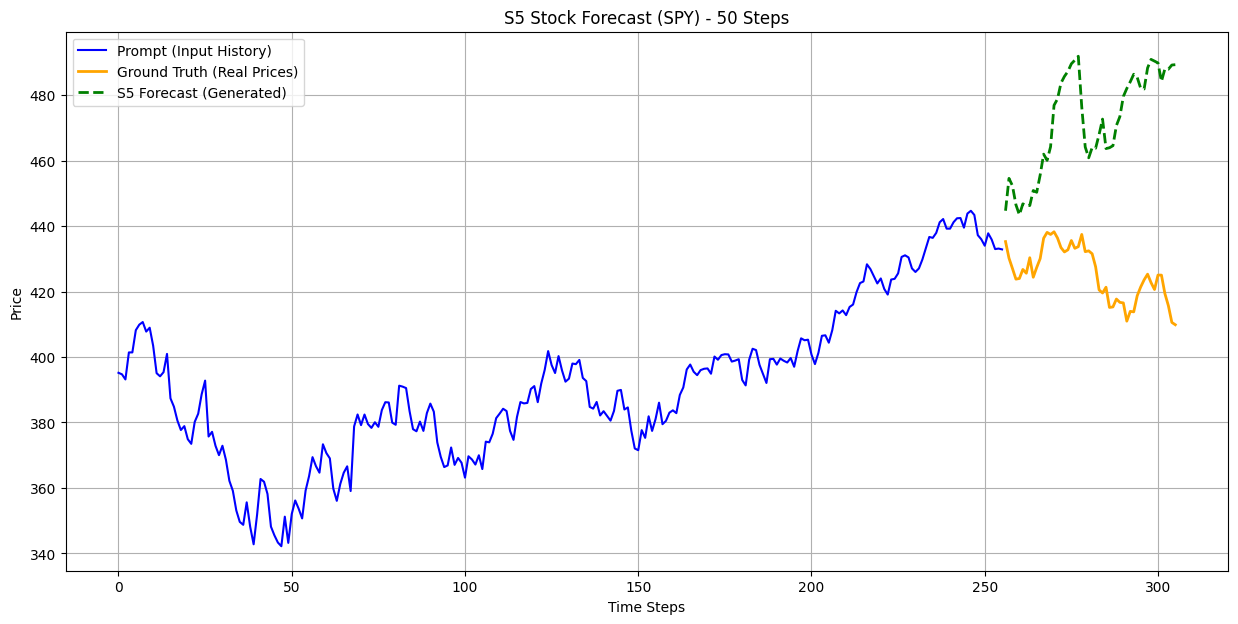

Plot saved to s5_logreturn_forecast.png


<Figure size 640x480 with 0 Axes>

In [19]:
# %%
# --- 6. Generate Forecast ---
print("[*] Generating forecast...")

# ⭐️ UPDATED: We need the *raw prices* for plotting and starting the decoder
# We find the index where the validation data *starts* in the original price array
# The log-returns shift everything by 1, so we add 1.
val_start_price_idx = split_idx + 1

# Get the prompt *tokens* (log-returns)
# This is the first PROMPT_LEN tokens from the validation set
# NEW CODE
prompt_tokens = val_data_tokens[:PROMPT_LEN].squeeze()

# Get the prompt *prices* (for plotting)
prompt_prices = price_data[val_start_price_idx : val_start_price_idx + PROMPT_LEN]

# Get the ground truth *tokens* (for decoding)
ground_truth_tokens = val_data_tokens[PROMPT_LEN : PROMPT_LEN + FORECAST_HORIZON]

# Get the ground truth *prices* (for plotting)
ground_truth_prices = price_data[
    val_start_price_idx + PROMPT_LEN :
    val_start_price_idx + PROMPT_LEN + FORECAST_HORIZON
]

# Find the price *just before* the ground truth starts, to seed the decoder
decode_start_price = price_data[val_start_price_idx + PROMPT_LEN - 1]

# --- 7. Generate new token IDs ---
print("[*] Calling generate_forecast...")
predicted_tokens = generate_forecast(
    forward.init,
    state.params,
    FORECAST_HORIZON,
    prompt_tokens,
    state.rng_key
)
print(f"Predicted tokens: {predicted_tokens}")

# --- 8. Decode and Plot Results ---
print("[*] Decoding and plotting results...")

# Decode the predicted tokens into prices
predicted_prices = tokeniser.decode(predicted_tokens, decode_start_price)

# Note: We already have the real `ground_truth_prices`
# We can also decode the `ground_truth_tokens` for comparison
decoded_ground_truth_prices = tokeniser.decode(ground_truth_tokens, decode_start_price)

plt.figure(figsize=(15, 7))
prompt_len = len(prompt_prices)
forecast_len = len(ground_truth_prices)

# X-axis indices
prompt_axis = jnp.arange(prompt_len)
forecast_axis = jnp.arange(prompt_len, prompt_len + forecast_len)

# Plot the prompt
plt.plot(prompt_axis, prompt_prices, label="Prompt (Input History)", color='blue')

# Plot the REAL ground truth
plt.plot(forecast_axis, ground_truth_prices, label="Ground Truth (Real Prices)", color='orange', linewidth=2)

# Plot the S5 forecast
plt.plot(forecast_axis, predicted_prices, label="S5 Forecast (Generated)", color='green', linestyle='--', linewidth=2)

# Optional: Plot the decoded ground truth to see tokeniser error
# plt.plot(forecast_axis, decoded_ground_truth_prices, label="Ground Truth (Decoded)", color='red', linestyle=':', linewidth=2)


plt.title(f"S5 Stock Forecast (SPY) - {FORECAST_HORIZON} Steps")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

plot_filename = 's5_logreturn_forecast.png'
plt.savefig(plot_filename)
print(f"Plot saved to {plot_filename}")